<a href="https://colab.research.google.com/github/GavinOckert/tsz_analysis/blob/main/act_map_stacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from astropy.io import fits
from google.colab import drive

drive.mount("/content/drive")
file_path = r"/content/drive/My Drive/act_dr5.01_s08s18_AA_f150_night_map.fits"
#Uses FITS file from Drive

#file_path = 'act_dr5.01_s08s18_AA_f150_night_map.fits'
#!wget -O {file_path} "https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr5/maps/act_dr5.01_s08s18_AA_f150_night_map.fits"
#Downloads directly from source

with fits.open(file_path) as hdul:
  act_map = hdul[0].data
  header = hdul[0].header

cdelt1 = header['CDELT1'] # in degrees
cdelt2 = header['CDELT2']

print(f"Pixel scale (cdelt1): {cdelt1 * 60 } arcminutes per pixel")
print(f"Pixel scale (cdelt2): {cdelt2 * 60 } arcminutes per pixel")

Mounted at /content/drive
Pixel scale (cdelt1): -0.499999999999998 arcminutes per pixel
Pixel scale (cdelt2): 0.499999999999998 arcminutes per pixel


In [2]:
import matplotlib.pyplot as plt
import numpy as np

vmin = np.percentile(act_map[0, :, :], 0.1)
vmax = np.percentile(act_map[0, :, :], 99.9)

print("Map shape:", act_map.shape)
print("Header info:", header)

Map shape: (3, 10320, 43200)
Header info: SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                43200                                                  NAXIS2  =                10320                                                  NAXIS3  =                    3                                                  CRPIX1  =              21601.0 / Pixel coordinate of reference point            CRPIX2  =               7561.0 / Pixel coordinate of reference point            CRPIX3  =                  1.0 / Pixel coordinate of reference point            CDELT1  =  -0.0083333333333333 / [deg] Coordinate increment at reference point  CDELT2  =   0.0083333333333333 / [deg] Coordinate increment at reference point  CDELT3  =                  1.0 / Coordinate increment at reference point      

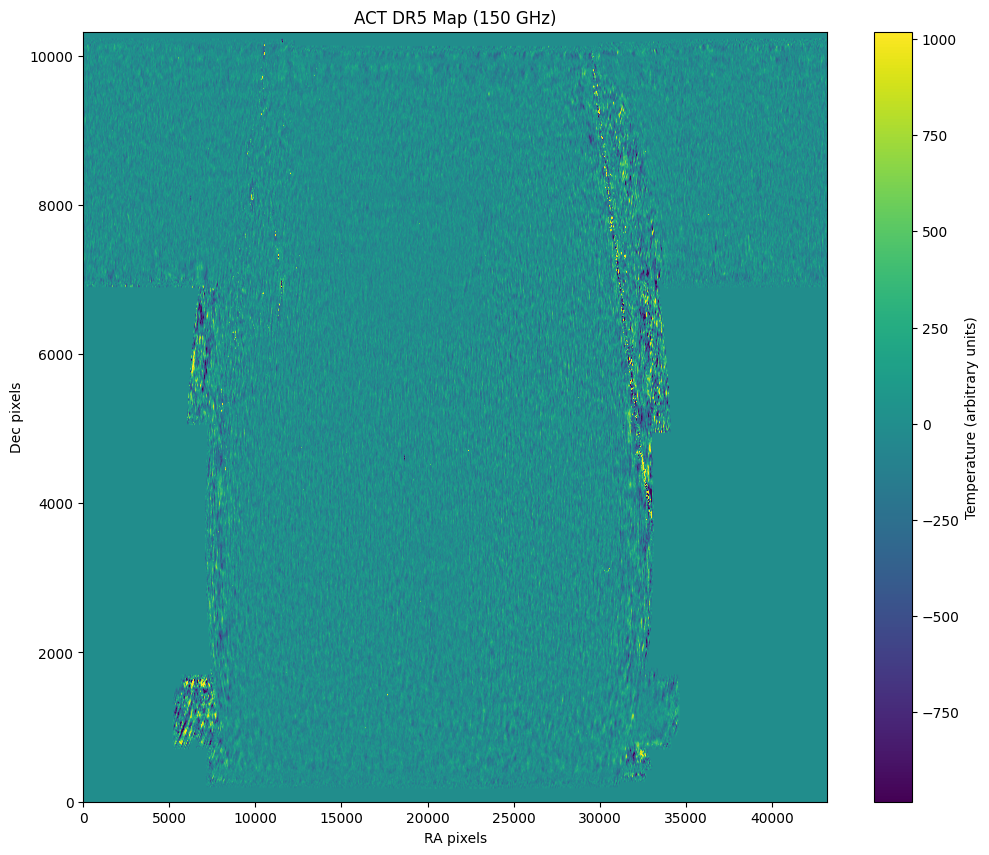

In [3]:
# Visualize
plt.figure(figsize=(12, 10))
plt.imshow(act_map[0, :, :], cmap='viridis', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label="Temperature (arbitrary units)")
plt.title("ACT DR5 Map (150 GHz)")
plt.xlabel("RA pixels")
plt.ylabel("Dec pixels")
plt.show()

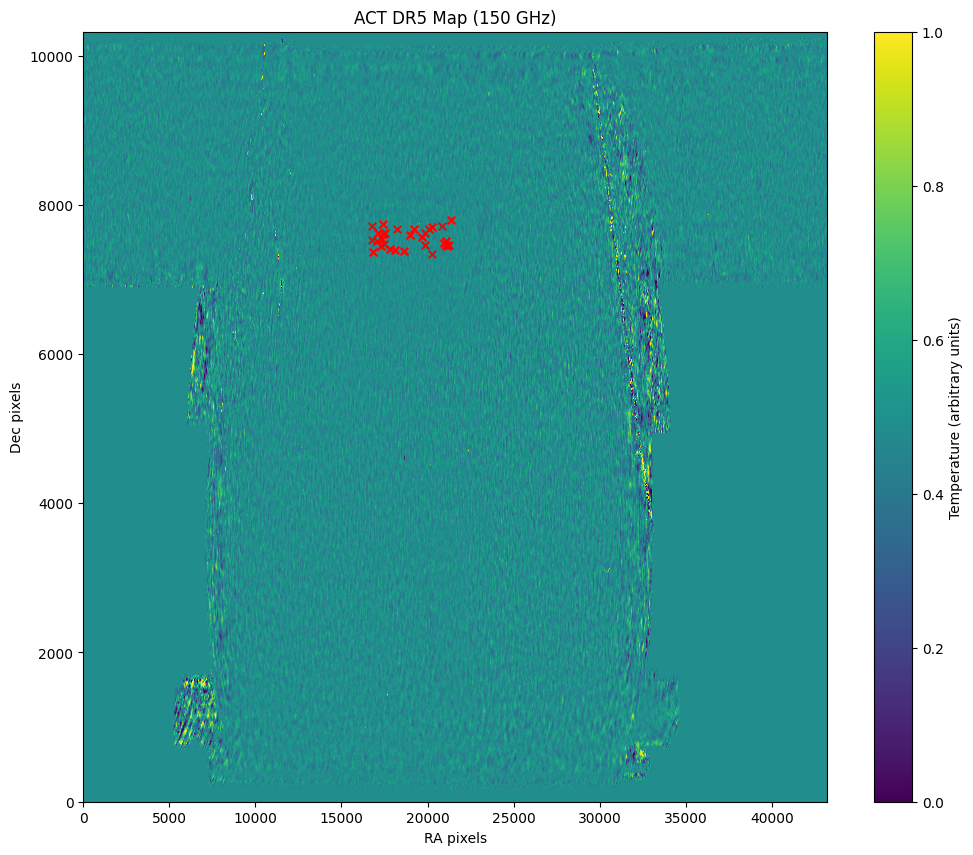

In [4]:
from astropy.wcs import WCS

wcs = WCS(header=hdul[0].header)

galaxy_wcs_coords = np.array([(2.0418, 2.0204), (3.0152, -0.7693), (3.7276, -0.9502), (4.4138, -0.8580), (4.5623, -0.3795), (5.5553, -0.6050), \
                (6.5699, 1.3367), (11.1076, 1.2221), (11.3051, -1.8827), (12.7875, 0.9323), (14.5189, 0.5106), (14.7855, -0.8326), \
                (16.2195, 0.0495), (19.9971, 0.9193), (21.8227, 0.3468), (24.8407, -1.4769), (28.1764, 1.0059), (29.1008, -1.3879), \
                (31.5567, -1.2428), (33.8699, 0.5091), (34.5626, -0.6883), (34.9533, 0.3755), (34.9759, 1.4973), (35.3925, -0.2063), \
                (35.7939, -0.9466), (37.1250, 0.5033), (37.7273, -0.4043), (39.9718, -1.5758), (40.0102, 1.2693), (40.3129, -0.3109)]) # (RA, Decl)

galaxy_ra = np.array([x[0] for x in galaxy_wcs_coords])
galaxy_decl = np.array([x[1] for x in galaxy_wcs_coords])
galaxy_dummy = np.zeros_like(galaxy_ra) # wcs.all_world2pix requires three arrays

galaxy_xcoords, galaxy_ycoords, galaxy_dummy_coords = wcs.all_world2pix(galaxy_ra, galaxy_decl, galaxy_dummy, 0)

plt.figure(figsize=(12, 10))
plt.imshow(act_map[0, :, :], cmap='viridis', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
plt.scatter(galaxy_xcoords, galaxy_ycoords, s = 30, c = 'red', marker = 'x', label = 'Coordinates')
plt.colorbar(label="Temperature (arbitrary units)")
plt.title("ACT DR5 Map (150 GHz)")
plt.xlabel("RA pixels")
plt.ylabel("Dec pixels")
plt.show()

In [5]:
pip install pixell

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 16.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=0d08481ae41fac43ac4067f95d2cea80b7ce0265a8588cf32fe70cf2acf1955f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


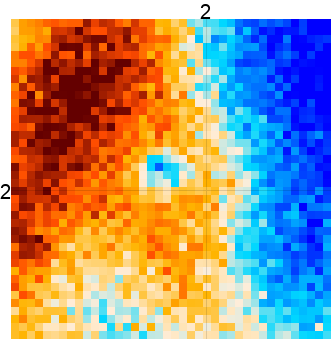

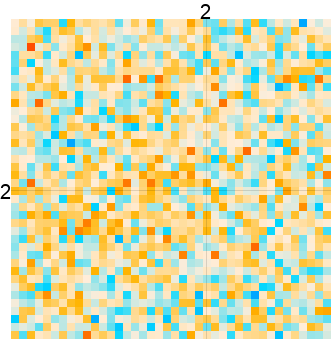

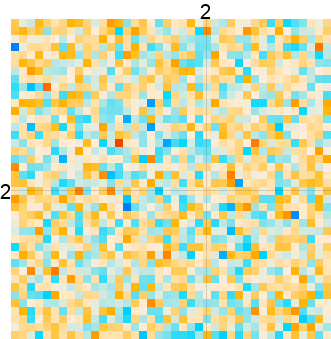

In [6]:
from pixell import enmap, utils, enplot

def galaxy_submap(ra, dec, radius): # ra and dec in degrees, radius in arcmin

  ra = ra * utils.degree
  dec = dec * utils.degree
  radius = radius * utils.arcmin

  box = np.array([[dec - radius, ra - radius], [dec + radius, ra + radius]])
  imap_box = enmap.read_map(file_path, box=box)

  return imap_box

imap_box = galaxy_submap(2.0418, 2.0204, 10)
plot = enplot.plot(imap_box, upgrade = 8)
enplot.show(plot)

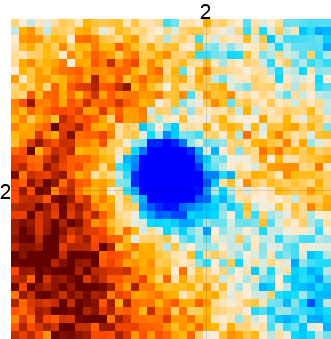

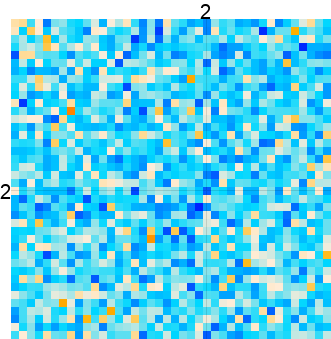

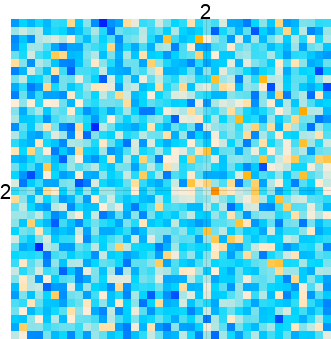

In [7]:
stack = 0
for n in range(len(galaxy_wcs_coords)):
  imap_box = galaxy_submap(galaxy_ra[n], galaxy_decl[n], 10)
  stack += imap_box

plot = enplot.plot(stack / len(galaxy_wcs_coords), upgrade = 8)
enplot.show(plot)